# Exploratory Data Analysis: Purchases and Markdown Patterns

## Purpose
The goal of this notebook is to explore purchase changes around markdown periods and identify patterns that can help demand prediction modeling.

## Work Completed
- 1. Data understanding and preparation: basic understanding the product and sales dataset (e.g. how to join, null value check, how many kinds of products)
- 2. Basic feature construction: extra column generation so as to outline patterns (e.g. whether it is in the markdown week or not, discount, price)
- 3. Purchase distribution analysis: visualization of the distribution of purchases 
- 4. Uplift analysis: visualization of uplift
- 5. Case-level inspection

## Summary
- Markdown triggers a strong demand response
- The effect is strongest in the first markdown week
- Deep discounts are effective early, inefficient later
- Products respond very differently to markdowns
- It looks promising to create a model for demand prediction

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import self-created classes
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent.parent) + "/weekend/src")
from data_prep import DataPrep

### Data understanding and preparation

In [0]:
path_to_prod = '../data/product_table.csv'
path_to_sales = '../data/sales_master.csv'
data_prep = DataPrep(path_to_prod, path_to_sales)
print(f"There are {data_prep.df_products.shape[0]} rows in the product table.")
print(f"There are {data_prep.df_sales.shape[0]} rows in the sales table.")
df = data_prep.data_merger()
print(f"There are {df.shape[0]} rows in the combined table.")
df.sample(5)

There are 702 rows in the product table.
There are 46694 rows in the sales table.
There are 46072 rows in the combined table.


/Workspace/Users/ming.zhan@if.se/SelfTraining/casestudy/weekend/src/data_prep.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['variant_parent'] = df_sales['variant'].map(lambda x: x//1000)


,date,variant,purchases,net_amount,gross_amount,variant_parent,PRODUCT_CODE,PRODUCT_TYPE_NAME,DEPARTMENT_ID,DEPARTMENT_NAME,INDEX_GROUP_NAME,SECTION_NAME,article,week
9362,2017-10-07,437444001038,4.0,94.144317,99.96,437444001,437444,Skirt,65,Skirt,Ladieswear,Ladies Modern Classic,437444001,week0
6698,2017-10-05,454537001052,1.0,28.646192,29.99,454537001,454537,Other dress,111,Woven top,Ladieswear,H&M+,454537001,week0
24930,2017-10-14,477027010000,27.0,104.931072,215.73,477027010,477027,Sunglasses,268,Sunglasses,Ladieswear,Ladies: Small accessories,477027010,week1
13979,2017-10-09,471678002004,23.0,160.597661,459.77,471678002,471678,T-shirt,932,Jersey,Divided,Grey Girl,471678002,week1
39146,2017-10-20,501406005038,2.0,20.896638,49.98,501406005,501406,Body,1239,Jersey ES inactive from S.6,Ladieswear,Ladies Trend,501406005,week2


### Basic feature construction

In [0]:
# Create columns for further analysis
df["week"] = (
    "week" +
    (pd.to_datetime(df["date"])
     .rank(method="dense")
     .sub(1)
     .floordiv(7)
     .astype(int)
     .astype(str))
)
df["price"] = np.where(
    df["purchases"] > 0,
    df["gross_amount"] / df["purchases"],
    np.nan
).round(2)
df["discount"] = np.where(
    df["gross_amount"] > 0,
    1 - df["net_amount"] / df["gross_amount"],
    0.0
).round(2)
num_cols = ["purchases", "net_amount", "gross_amount", 'price','discount']
df[num_cols].describe().round(2)

,purchases,net_amount,gross_amount,price,discount
count,46072.00,46072.00,46072.00,39893.00,46072.00
mean,9.79,107.60,180.29,21.85,0.28
std,26.71,276.48,455.88,14.81,0.27
min,0.00,0.00,0.00,0.99,0.00
25%,1.00,12.14,19.98,9.99,0.04
50%,3.00,38.16,59.97,17.99,0.19
75%,9.00,107.35,179.88,29.99,0.47
max,1535.00,20457.46,30684.65,149.00,0.90


### Purchase distribution analysis

<Axes: >

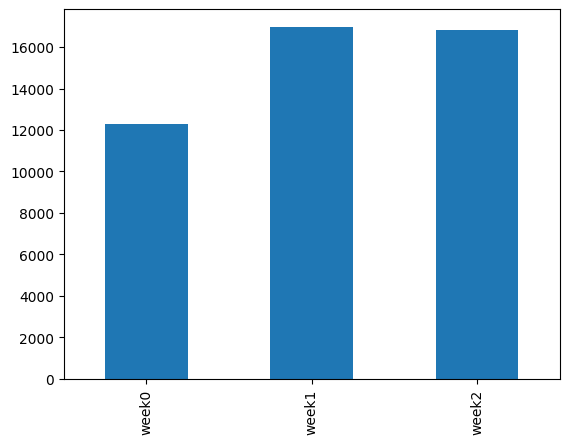

In [0]:
df['week'].value_counts().sort_index().plot(kind='bar')

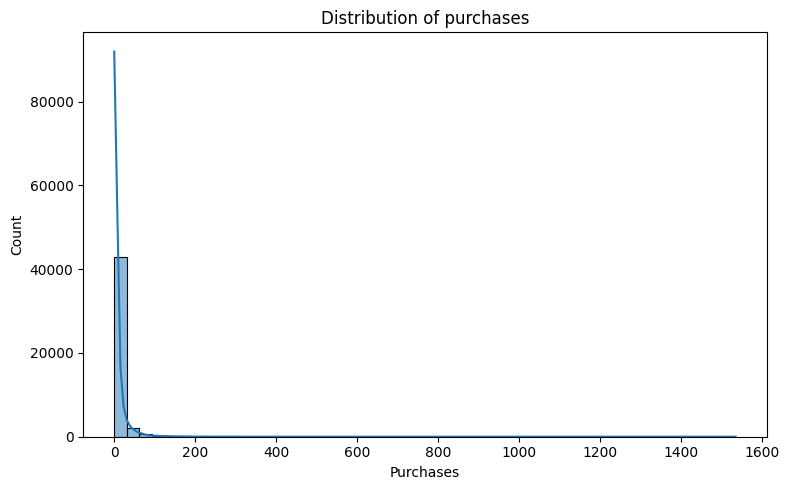

In [0]:
# Check the distribution of purchases
upper = int(df["purchases"].quantile(0.99))
col = 'purchases'
plt.figure(figsize=(8, 5))
sns.histplot(df[col], bins=50, kde=True)
plt.title(f"Distribution of purchases")
plt.xlabel("Purchases")
plt.tight_layout()
plt.show()

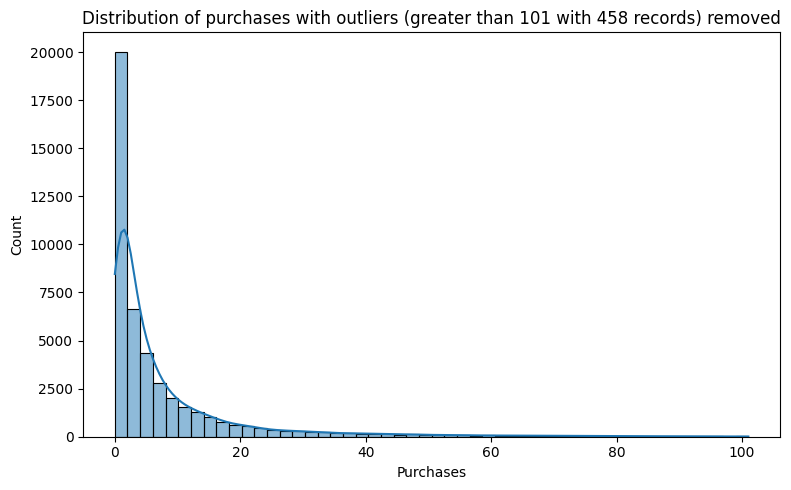

In [0]:
plt.figure(figsize=(8, 5))
sns.histplot(df.loc[df[col] <= upper, col], bins=50, kde=True)
plt.title(f"Distribution of purchases with outliers (greater than {upper} with {len(df.loc[df[col] > upper, col])} records) removed")
plt.xlabel("Purchases")
plt.tight_layout()
plt.show()

In [0]:
df.loc[df[col] > upper]['week'].value_counts()

week1    251
week2    185
week0     22
Name: week, dtype: int64

In [0]:
df[df['discount']>0.8]['week'].value_counts()

week2    1879
week1     688
Name: week, dtype: int64

### Uplift analysis

In [0]:
## create aggration for further analysis
group_cols = ["week","INDEX_GROUP_NAME", "DEPARTMENT_NAME", "PRODUCT_TYPE_NAME"]
avg_cols = ['price','discount']
sum_col = ['purchases']
df_agg = (
    df
    .groupby(group_cols, as_index=False)
    .agg(
        purchases=("purchases", "sum"),
        price=("price", "mean"),
        discount=("discount", "mean"),
    )
)
df_agg[["price", "discount"]] = df_agg[["price", "discount"]].round(2)

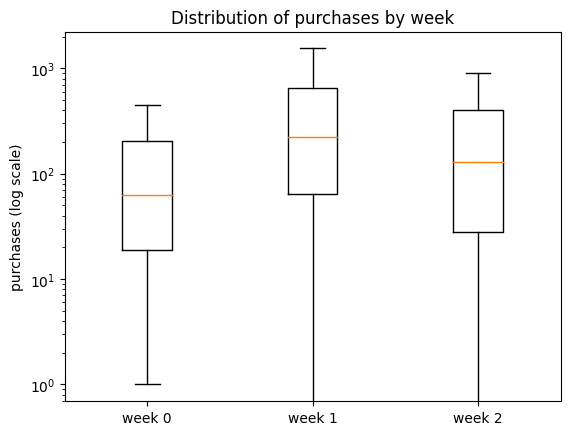

In [0]:
data = [
    df_agg.loc[df_agg["week"] == 'week0', "purchases"],
    df_agg.loc[df_agg["week"] == 'week1', "purchases"],
    df_agg.loc[df_agg["week"] == 'week2', "purchases"],
]

plt.figure()
plt.boxplot(data, labels=["week 0", "week 1", "week 2"], showfliers=False)
plt.yscale("log")
plt.ylabel("purchases (log scale)")
plt.title("Distribution of purchases by week")
plt.show()

In [0]:
keys = ["INDEX_GROUP_NAME", "DEPARTMENT_NAME", "PRODUCT_TYPE_NAME"]

# Baseline demand (week 0)
baseline = (
    df_agg[df_agg["week"] == 'week0']
    .loc[:, keys + ["purchases"]]
    .rename(columns={"purchases": "purchases_w0"})
)

# Join baseline to all weeks
df_uplift = df_agg.merge(baseline, on=keys, how="left")
df_uplift["uplift"] = df_uplift["purchases"] / df_uplift["purchases_w0"]

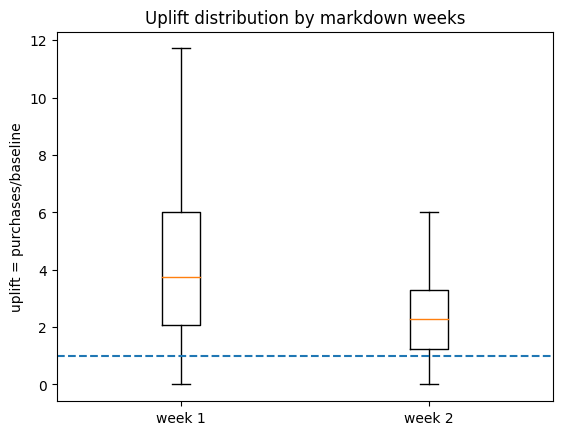

In [0]:
data = [
    df_uplift.loc[df_uplift["week"] == 'week1', "uplift"].dropna(),
    df_uplift.loc[df_uplift["week"] == 'week2', "uplift"].dropna(),
]

plt.figure()
plt.boxplot(data, labels=["week 1", "week 2"], showfliers=False)
plt.axhline(1.0, linestyle="--")
plt.title("Uplift distribution by markdown weeks")
plt.ylabel("uplift = purchases/baseline")
plt.show()

In [0]:
# keep only markdown weeks
df_md = df_uplift[df_uplift["week"].isin(['week1', 'week2'])].copy()

# create quartiles of discount rate
# Q1 (low) : (0-0.2], Q2 : (0.2-0.3], Q3 : (0.3-0.51], Q4 (high) : (0.51, 1]
df_md["discount_q"] = pd.qcut(
    df_md["discount"],
    q=4,
    labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
)


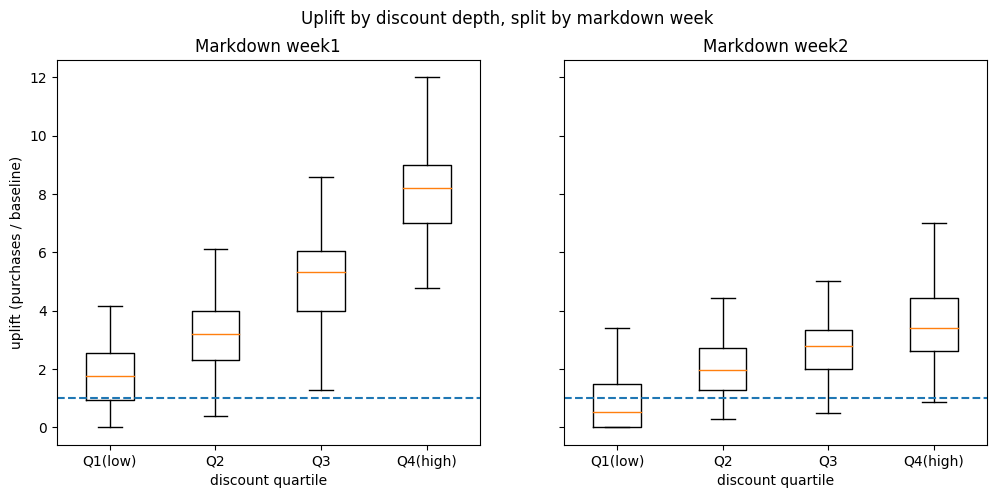

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, wk in zip(axes, ['week1', 'week2']):
    groups = [
        df_md.loc[
            (df_md["week"] == wk) & (df_md["discount_q"] == q),
            "uplift"
        ].dropna()
        for q in ["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
    ]

    ax.boxplot(groups, labels=["Q1(low)", "Q2", "Q3", "Q4(high)"], showfliers=False)
    ax.axhline(1.0, linestyle="--")
    ax.set_title(f"Markdown {wk}")
    ax.set_xlabel("discount quartile")

axes[0].set_ylabel("uplift (purchases / baseline)")
fig.suptitle("Uplift by discount depth, split by markdown week")
plt.show()

In [0]:
keys = ["INDEX_GROUP_NAME", "DEPARTMENT_NAME", "PRODUCT_TYPE_NAME"]

pivot = (
    df_uplift
    .pivot_table(
        index=keys,
        columns="week",
        values="purchases",
        aggfunc="sum"
    )
    .reset_index()
)
pivot["uplift_w1"] = pivot["week1"] / pivot["week0"]
pivot["uplift_w2"] = pivot["week2"] / pivot["week0"]

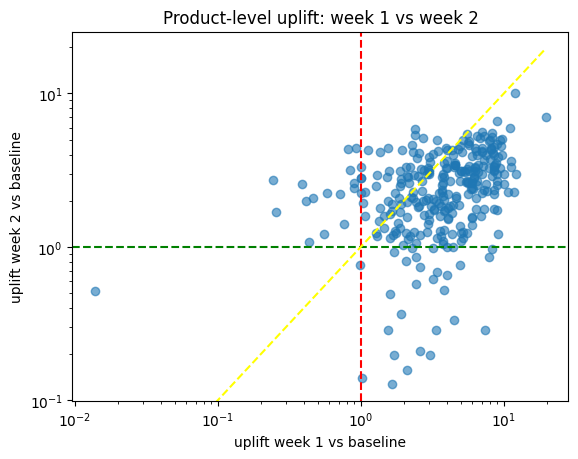

In [0]:
plt.figure()
plt.scatter(pivot["uplift_w1"], pivot["uplift_w2"], alpha=0.6)
plt.axvline(1.0, linestyle="--", color='red')
plt.axhline(1.0, linestyle="--", color = 'green')
plt.plot(
    [pivot["uplift_w1"].min(), pivot["uplift_w1"].max()],
    [pivot["uplift_w1"].min(), pivot["uplift_w1"].max()],
    linestyle="--", color = 'yellow'
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("uplift week 1 vs baseline")
plt.ylabel("uplift week 2 vs baseline")
plt.title("Product-level uplift: week 1 vs week 2")
plt.show()

### Case-level inspection

In [0]:
df_agg[
    (df_agg["INDEX_GROUP_NAME"] == "Menswear")
    & (df_agg["DEPARTMENT_NAME"] == 'Knitwear')
    & (df_agg["PRODUCT_TYPE_NAME"] == 'Jumper/Sweater')
]

,week,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME,purchases,price,discount
310,week0,Menswear,Knitwear,Jumper/Sweater,410.0,30.29,0.05
645,week1,Menswear,Knitwear,Jumper/Sweater,2694.0,31.09,0.48
980,week2,Menswear,Knitwear,Jumper/Sweater,1255.0,31.53,0.41


In [0]:
df_agg[
    (df_agg["INDEX_GROUP_NAME"] == "Ladieswear")
    & (df_agg["DEPARTMENT_NAME"] == 'Lingerie Programs')
    & (df_agg["PRODUCT_TYPE_NAME"] == 'Body')
]

,week,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME,purchases,price,discount
235,week0,Ladieswear,Lingerie Programs,Body,10.0,24.99,0.05
570,week1,Ladieswear,Lingerie Programs,Body,61.0,24.99,0.33
905,week2,Ladieswear,Lingerie Programs,Body,0.0,NaN,0.00


In [0]:
# example that model might not make good predictions
df_agg[
    (df_agg["INDEX_GROUP_NAME"] == "Baby/Children")
    & (df_agg["DEPARTMENT_NAME"] == 'Accessories big boy')
    & (df_agg["PRODUCT_TYPE_NAME"] == 'Sunglasses')
]

,week,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME,purchases,price,discount
2,week0,Baby/Children,Accessories big boy,Sunglasses,104.0,5.99,0.04
337,week1,Baby/Children,Accessories big boy,Sunglasses,0.0,NaN,0.00
672,week2,Baby/Children,Accessories big boy,Sunglasses,109.0,5.99,0.75


In [0]:
df[
    (df["INDEX_GROUP_NAME"] == "Baby/Children")
    & (df["DEPARTMENT_NAME"] == 'Accessories big boy')
    & (df["PRODUCT_TYPE_NAME"] == 'Sunglasses')
][['week','purchases']]

,week,purchases
793,week0,16.0
2796,week0,15.0
4062,week0,15.0
5942,week0,26.0
7060,week0,13.0
9071,week0,12.0
11613,week0,7.0
13068,week1,0.0
16720,week1,0.0
18402,week1,0.0
